In [1]:
!pip install pytesseract pdf2image opencv-python numpy Pillow matplotlib tqdm
!sudo apt-get install tesseract-ocr-ara
!apt-get install poppler-utils
!pip install pdf2image
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!sudo apt-get install tesseract-ocr-ara

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-ara tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,461 kB of archives.
After this operation, 17.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ara all 1:4.00~git30-7274cfa-1.1 [645 kB]
Fetched 5,461 kB in 1s (5,470 kB/s)
debconf: unable to ini

In [2]:
import os
import cv2
import pytesseract
from pdf2image import convert_from_path
from tqdm import tqdm
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define pytesseract configurations
def get_tesseract_config(language='eng'):
    return f'-l {language} --oem 1 --psm 6'


In [4]:
def create_bounding_box(bbox_data):
    left, top, width, height = bbox_data
    right = left + width
    bottom = top + height
    return [left, top, right, bottom]

In [5]:
def draw_and_extract_boxes(image, results, output_dir="output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    extracted_data = []


    for i, (bbox, text, prob) in enumerate(results):
        print(f"Text: {text}, Probability: {prob:.4f}")
        left, top, right, bottom = create_bounding_box(bbox)

        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)


        roi = image[top:bottom, left:right]           # Extract the region of interest (ROI)

        roi_filename = os.path.join(output_dir, f"extracted_text_{i+1}.png")
        cv2.imwrite(roi_filename, roi)


        extracted_data.append({
            "text": text,
            "confidence": float(prob),
            "bounding_box": {
                "left": left,
                "top": top,
                "right": right,
                "bottom": bottom
            },
            "roi_image_path": roi_filename
        })

    return image, extracted_data



In [6]:
def save_annotated_pages_as_pdf(annotated_images, output_pdf_path):
    pil_images = [Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in annotated_images]
    pil_images[0].save(output_pdf_path, save_all=True, append_images=pil_images[1:])
    print(f"Annotated PDF saved to {output_pdf_path}")


In [7]:
#  Perform OCR on PDF and save results
def ocr_pdf_to_individual_json(pdf_path, language='eng', output_dir="output_pdf_pages", save_pdf=True):
    pages = convert_from_path(pdf_path, dpi=300)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    annotated_images = []
    ocr_results = []


    font_path = "/content/DejaVuSansCondensed-Bold.ttf"

    for i, page in enumerate(tqdm(pages, desc="Processing pages")):
        print(f"Processing page {i + 1}...")

        page_image = np.array(page)
        page_image = cv2.cvtColor(page_image, cv2.COLOR_RGB2BGR)

        config = get_tesseract_config(language=language)
        data = pytesseract.image_to_data(page_image, config=config, output_type=pytesseract.Output.DICT)

        results = list(zip(
            zip(data['left'], data['top'], data['width'], data['height']),
            data['text'],
            data['conf']
        ))


        results = [result for result in results if result[1].strip() and int(result[2]) > 0]


        page_image_with_boxes, extracted_data = draw_and_extract_boxes(page_image, results, output_dir)


        annotated_images.append(page_image_with_boxes)


        ocr_results.append({
            "page_number": i + 1,
            "extracted_data": extracted_data
        })


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 24))

        original_image = Image.fromarray(cv2.cvtColor(page_image, cv2.COLOR_BGR2RGB))


        text_image = Image.new("RGB", original_image.size, (255, 255, 255))       #  for displaying the extracted text.
        draw = ImageDraw.Draw(text_image)

        try:
            font = ImageFont.truetype(font_path, 60)
        except IOError:
            font = ImageFont.load_default()

        page_text = "\n".join([item['text'] for item in extracted_data])
        draw.text((10, 10), page_text, fill="black", font=font)

        ax1.imshow(original_image)
        ax2.imshow(text_image)
        ax1.axis("off")
        ax2.axis("off")
        plt.show()


    if save_pdf:
        output_pdf_path = os.path.join(output_dir, "annotated_output.pdf")
        save_annotated_pages_as_pdf(annotated_images, output_pdf_path)


    json_output_path = os.path.join(output_dir, "ocr_results.json")
    with open(json_output_path, "w", encoding="utf-8") as json_file:
        json.dump(ocr_results, json_file, indent=4, ensure_ascii=False)

    print(f"OCR results saved to {json_output_path}")


Processing pages:   0%|          | 0/5 [00:00<?, ?it/s]

Processing page 1...
Text: Life, Probability: 96.0000
Text: Lite, Probability: 93.0000
Text: is, Probability: 95.0000
Text: like, Probability: 96.0000
Text: a, Probability: 94.0000
Text: journey, Probability: 94.0000
Text: filled, Probability: 96.0000
Text: with, Probability: 96.0000
Text: ups, Probability: 95.0000
Text: and, Probability: 96.0000
Text: downs., Probability: 95.0000
Text: It's, Probability: 91.0000
Text: a, Probability: 94.0000
Text: mix, Probability: 95.0000
Text: of, Probability: 96.0000
Text: joy, Probability: 96.0000
Text: and, Probability: 94.0000
Text: sorrow,, Probability: 94.0000
Text: success, Probability: 96.0000
Text: and, Probability: 96.0000
Text: failure., Probability: 95.0000
Text: Each, Probability: 96.0000
Text: day, Probability: 96.0000
Text: brings, Probability: 96.0000
Text: new, Probability: 88.0000
Text: experiences, Probability: 79.0000
Text: and_, Probability: 79.0000
Text: challenges,, Probability: 92.0000
Text: shaping, Probability: 96.0000
Text

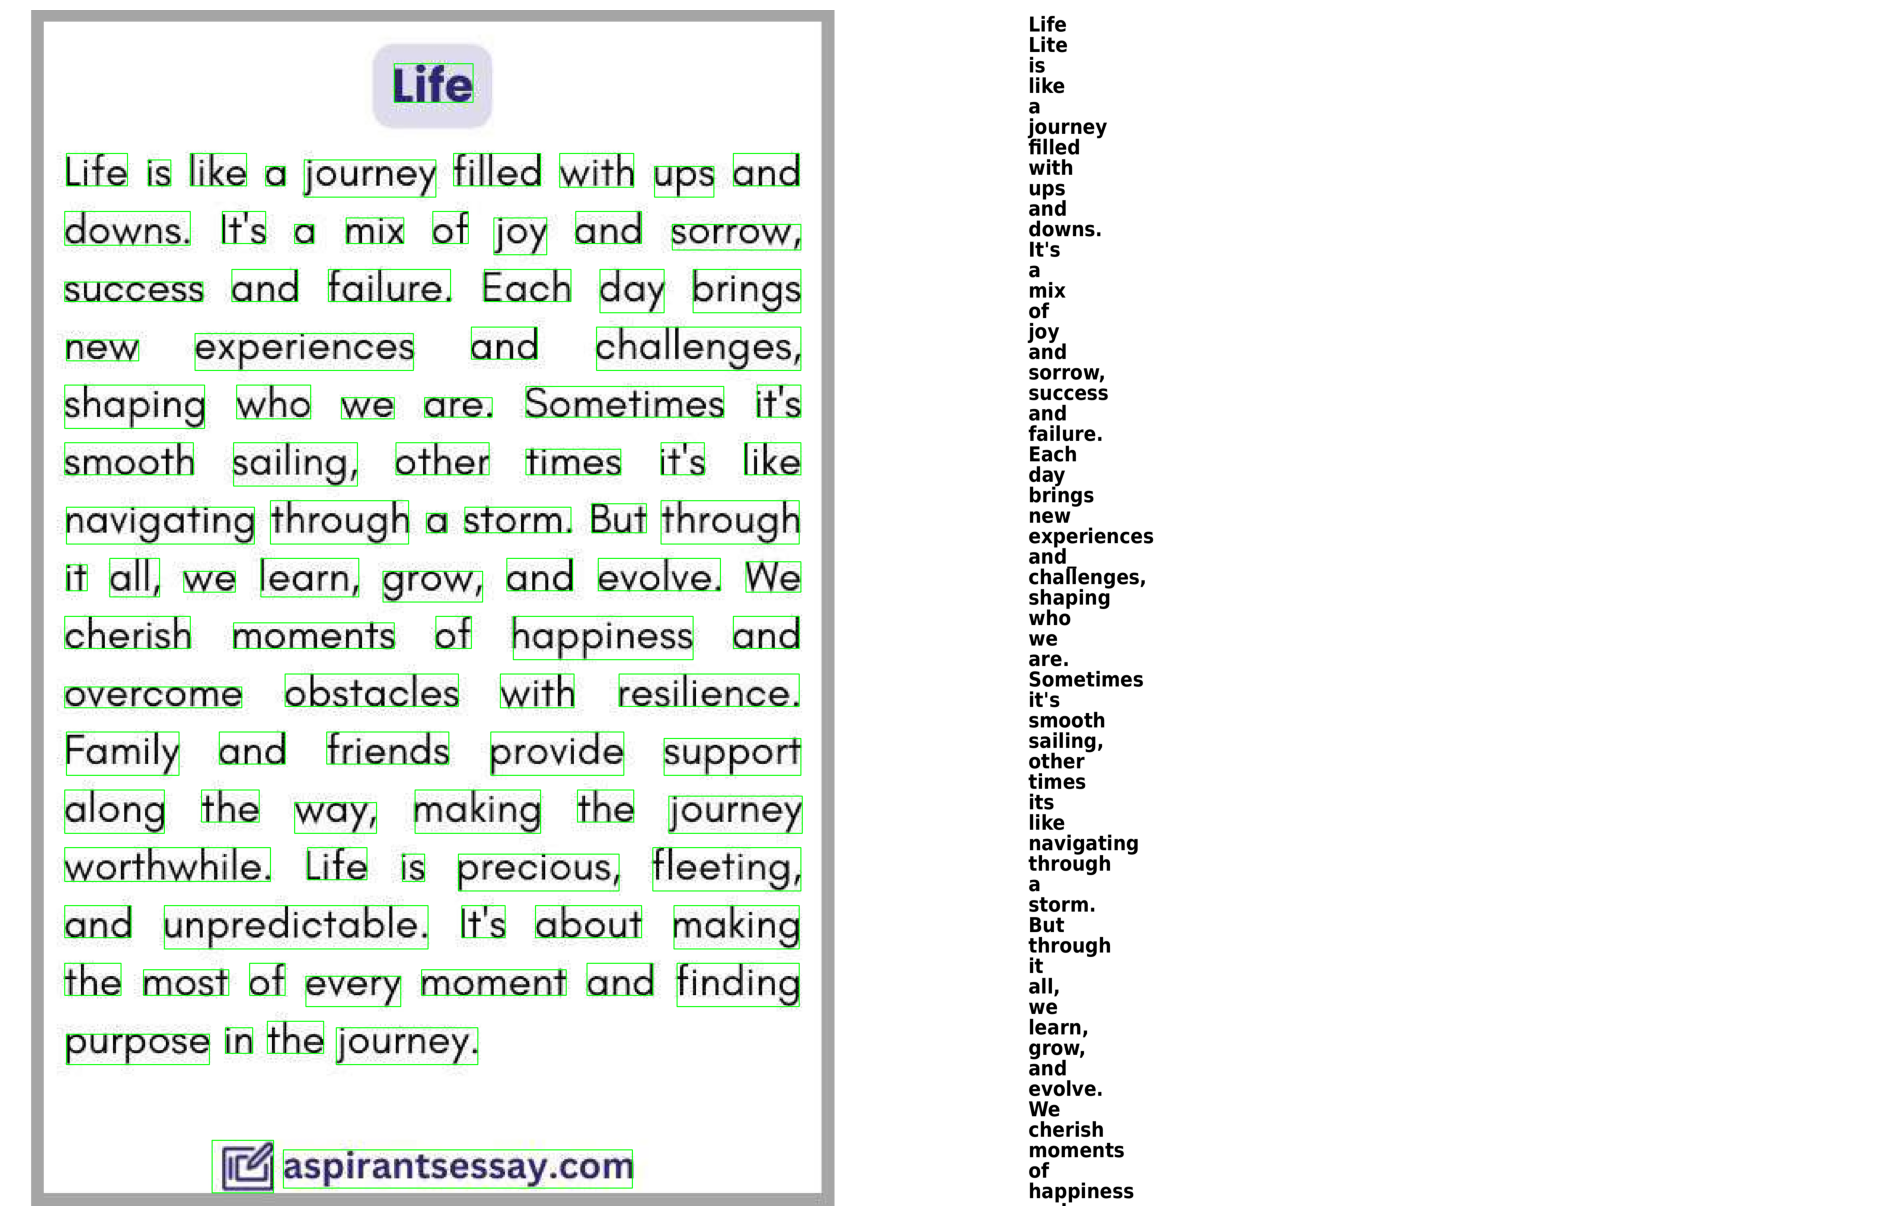

Processing pages:  20%|██        | 1/5 [00:12<00:50, 12.63s/it]

Processing page 2...
Text: Hobbies, Probability: 93.0000
Text: are, Probability: 96.0000
Text: like, Probability: 94.0000
Text: little, Probability: 94.0000
Text: pockets, Probability: 86.0000
Text: of, Probability: 86.0000
Text: happiness, Probability: 91.0000
Text: in, Probability: 91.0000
Text: our, Probability: 91.0000
Text: lives., Probability: 93.0000
Text: Mine, Probability: 78.0000
Text: is, Probability: 52.0000
Text: gardening., Probability: 96.0000
Text: |, Probability: 96.0000
Text: find, Probability: 92.0000
Text: solace, Probability: 96.0000
Text: in, Probability: 94.0000
Text: nurturing, Probability: 94.0000
Text: plants, Probability: 95.0000
Text: and, Probability: 96.0000
Text: watching, Probability: 96.0000
Text: them, Probability: 96.0000
Text: grow., Probability: 96.0000
Text: There's, Probability: 88.0000
Text: something, Probability: 96.0000
Text: magical, Probability: 95.0000
Text: about, Probability: 95.0000
Text: seeing, Probability: 96.0000
Text: a, Probability

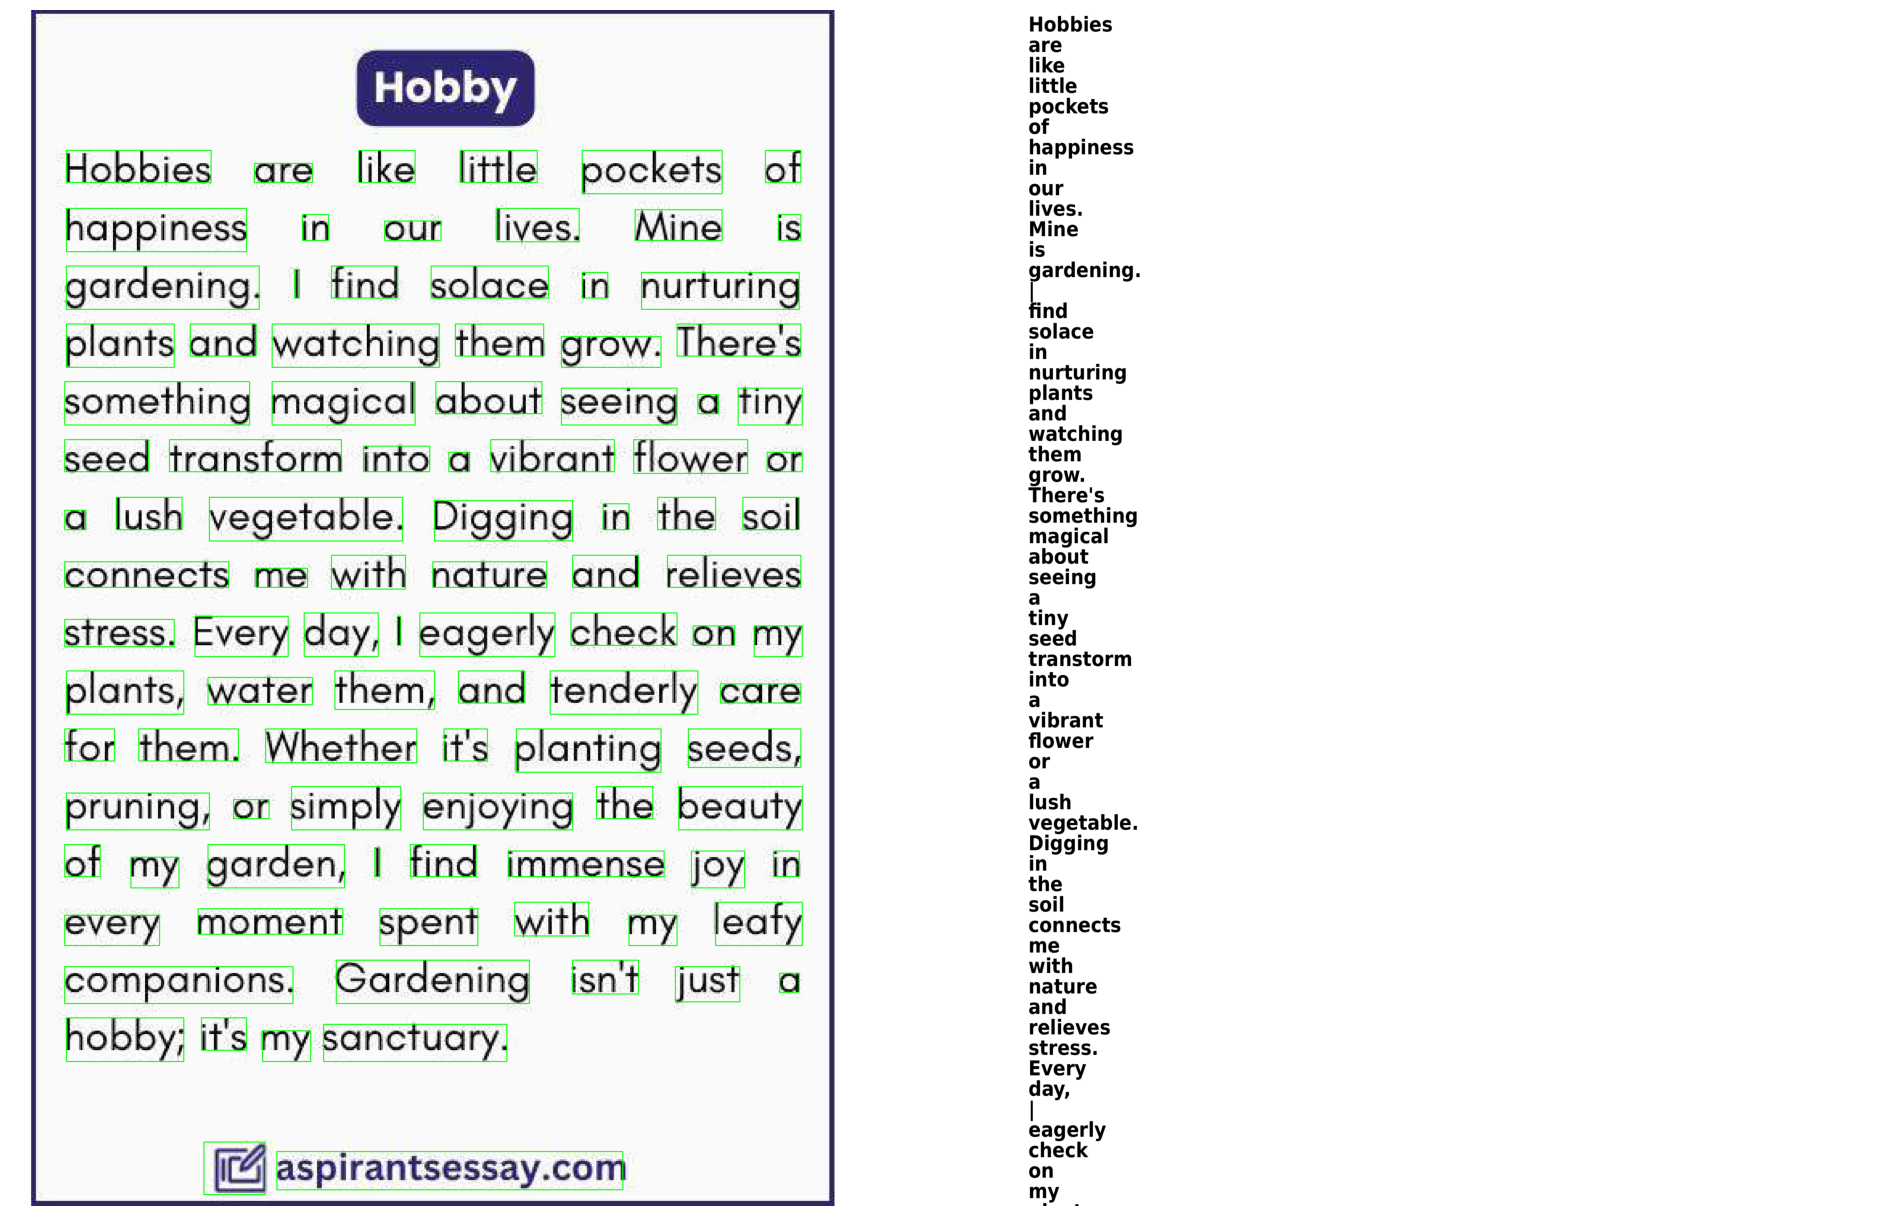

Processing pages:  40%|████      | 2/5 [00:18<00:25,  8.66s/it]

Processing page 3...
Text: Hard, Probability: 95.0000
Text: work, Probability: 96.0000
Text: is, Probability: 96.0000
Text: the, Probability: 96.0000
Text: key, Probability: 96.0000
Text: to, Probability: 96.0000
Text: success., Probability: 96.0000
Text: It, Probability: 95.0000
Text: requires, Probability: 95.0000
Text: dedication, Probability: 95.0000
Text: and, Probability: 49.0000
Text: _, Probability: 49.0000
Text: consistent, Probability: 96.0000
Text: effort., Probability: 94.0000
Text: By, Probability: 96.0000
Text: working, Probability: 93.0000
Text: hard,, Probability: 95.0000
Text: we, Probability: 86.0000
Text: can, Probability: 86.0000
Text: achieve, Probability: 96.0000
Text: our, Probability: 96.0000
Text: goals, Probability: 95.0000
Text: and, Probability: 96.0000
Text: improve, Probability: 94.0000
Text: our, Probability: 95.0000
Text: abilities., Probability: 94.0000
Text: Hard, Probability: 88.0000
Text: work, Probability: 95.0000
Text: teaches, Probability: 45.0000

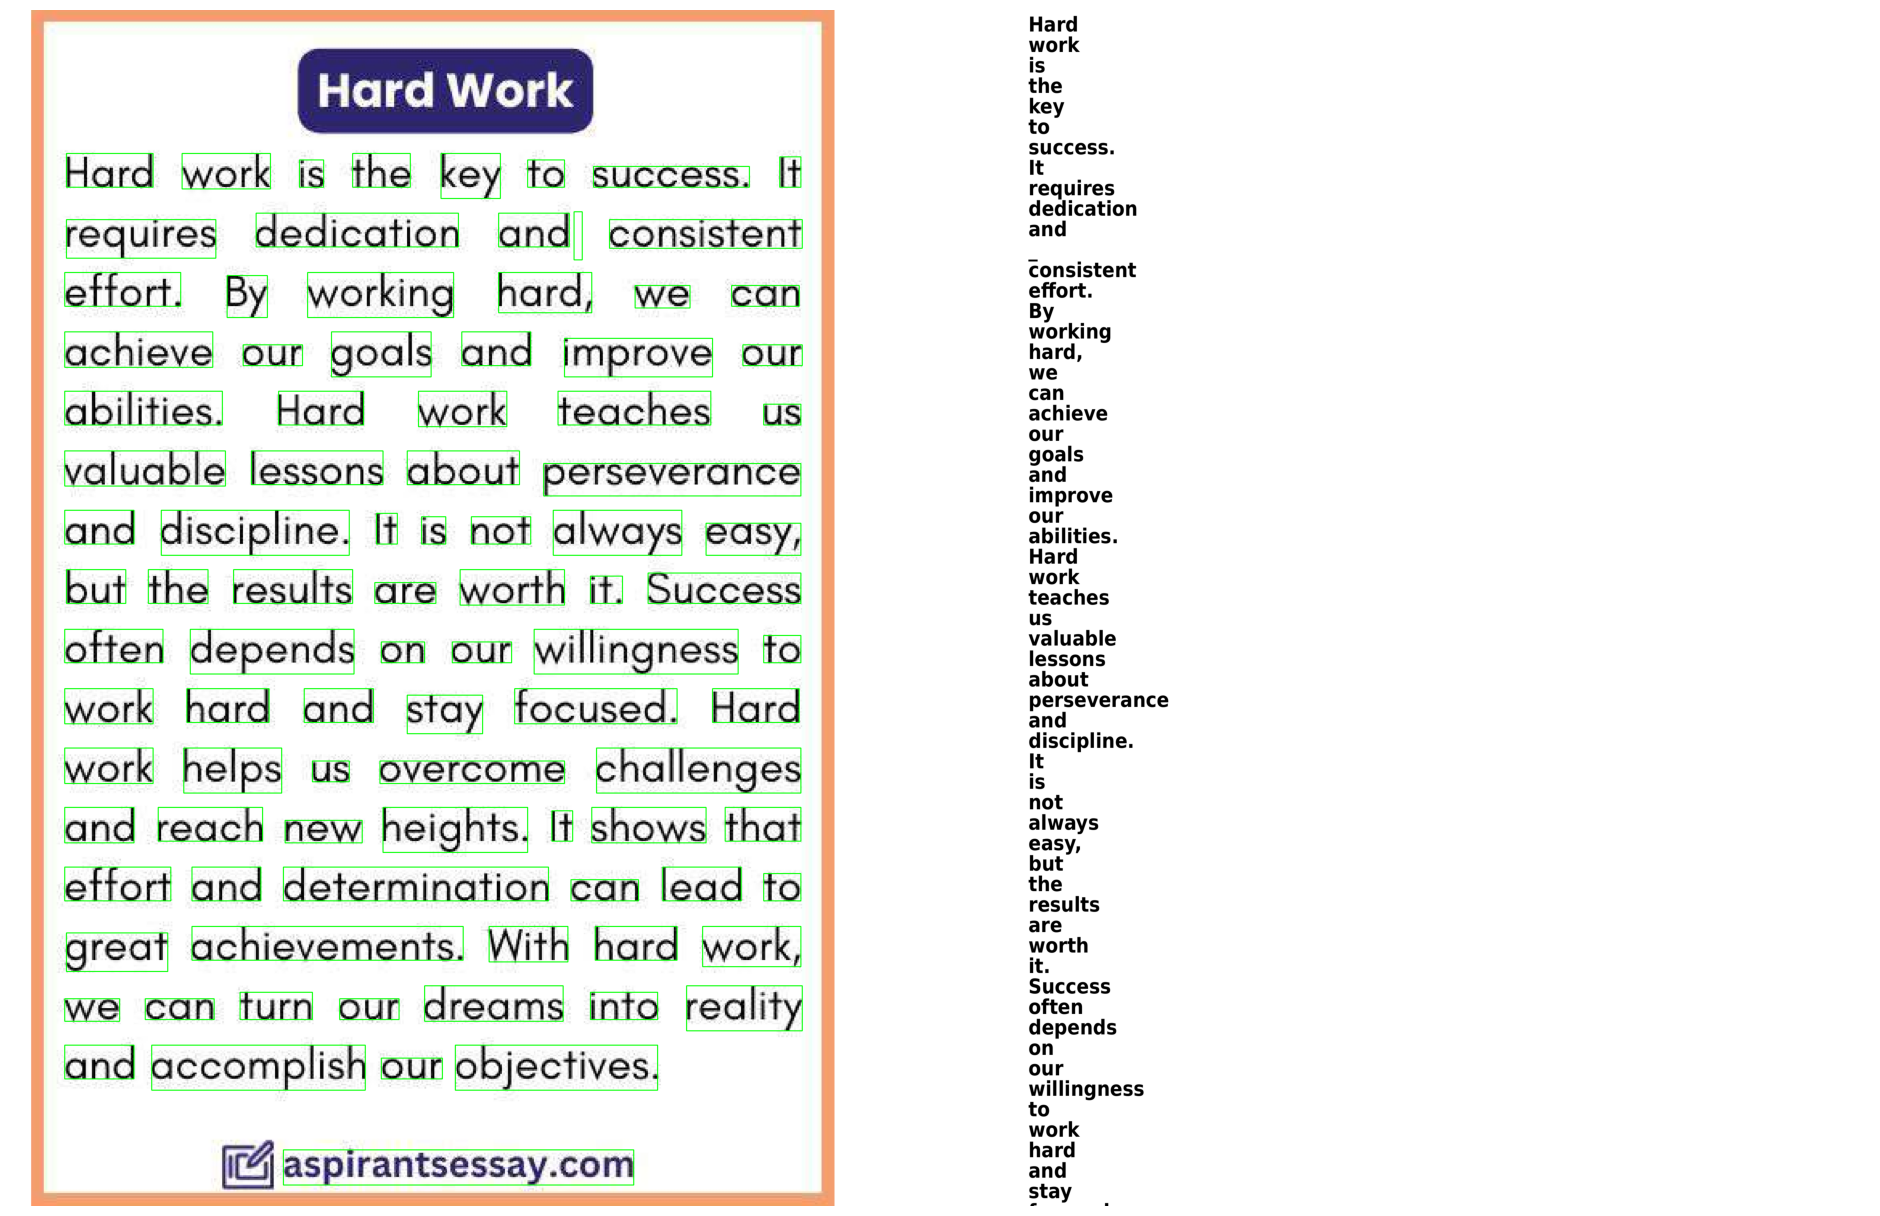

Processing pages:  60%|██████    | 3/5 [00:25<00:16,  8.12s/it]

Processing page 4...
Text: English, Probability: 96.0000
Text: is, Probability: 95.0000
Text: incredibly, Probability: 95.0000
Text: important, Probability: 95.0000
Text: in, Probability: 93.0000
Text: our, Probability: 95.0000
Text: world, Probability: 96.0000
Text: today., Probability: 96.0000
Text: It's, Probability: 94.0000
Text: like, Probability: 96.0000
Text: a, Probability: 96.0000
Text: key, Probability: 96.0000
Text: that, Probability: 96.0000
Text: unlocks, Probability: 96.0000
Text: many, Probability: 96.0000
Text: doors., Probability: 96.0000
Text: When, Probability: 96.0000
Text: you, Probability: 95.0000
Text: speak, Probability: 95.0000
Text: English, Probability: 95.0000
Text: well,, Probability: 96.0000
Text: you, Probability: 96.0000
Text: can, Probability: 95.0000
Text: talk, Probability: 96.0000
Text: with, Probability: 96.0000
Text: people, Probability: 96.0000
Text: trom, Probability: 90.0000
Text: all, Probability: 89.0000
Text: over, Probability: 96.0000
Text: 

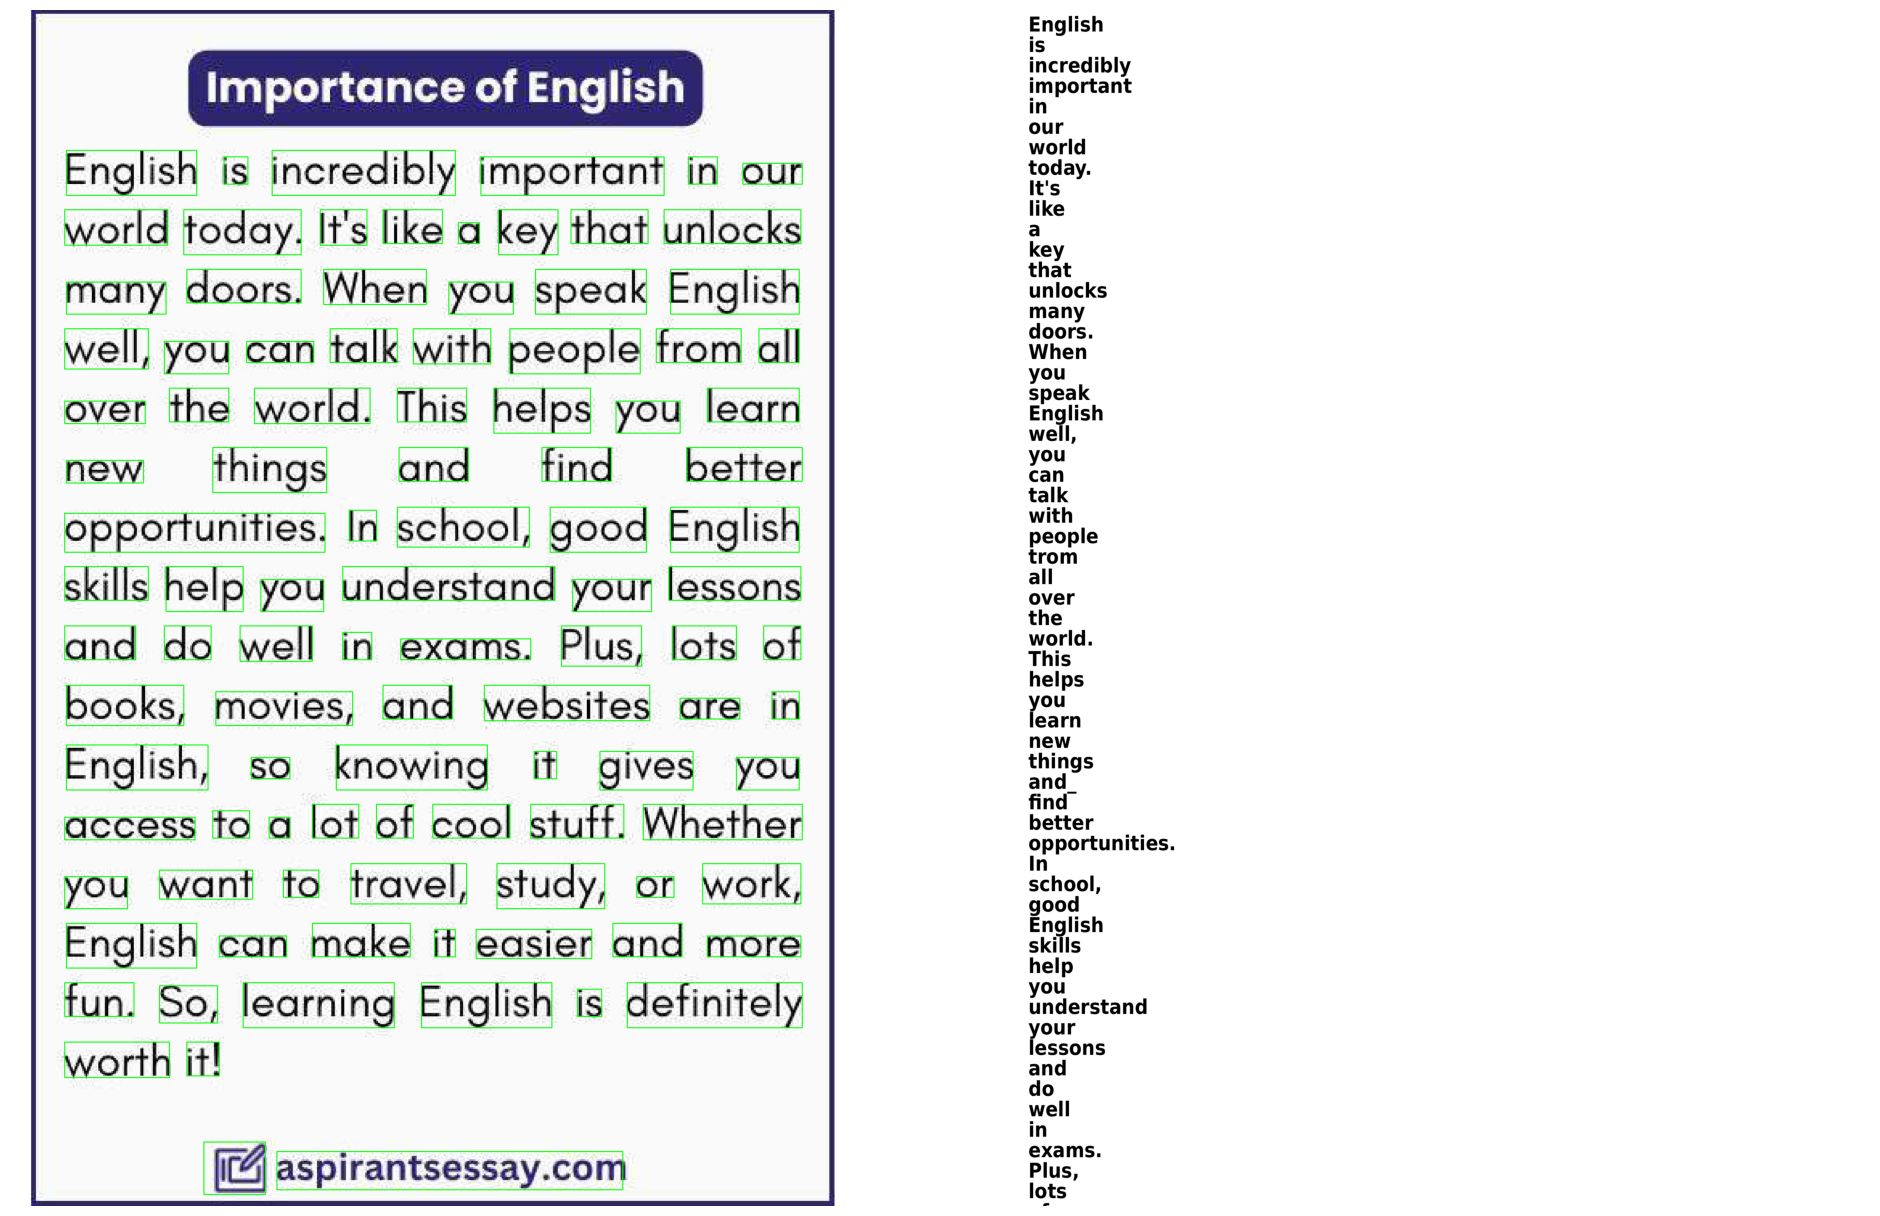

Processing pages:  80%|████████  | 4/5 [00:31<00:07,  7.26s/it]

Processing page 5...
Text: Good, Probability: 94.0000
Text: Habits, Probability: 94.0000
Text: Good, Probability: 96.0000
Text: habits, Probability: 96.0000
Text: are, Probability: 95.0000
Text: essential, Probability: 96.0000
Text: for, Probability: 94.0000
Text: success., Probability: 96.0000
Text: Waking, Probability: 96.0000
Text: up, Probability: 96.0000
Text: early, Probability: 96.0000
Text: ensures, Probability: 96.0000
Text: a, Probability: 93.0000
Text: productive, Probability: 93.0000
Text: day., Probability: 96.0000
Text: Planning, Probability: 96.0000
Text: ahead, Probability: 95.0000
Text: aids, Probability: 96.0000
Text: in, Probability: 96.0000
Text: managing, Probability: 96.0000
Text: time, Probability: 94.0000
Text: efficiently., Probability: 22.0000
Text: Regular, Probability: 96.0000
Text: exercise, Probability: 96.0000
Text: keeps, Probability: 96.0000
Text: the, Probability: 95.0000
Text: body, Probability: 96.0000
Text: healthy, Probability: 96.0000
Text: and, P

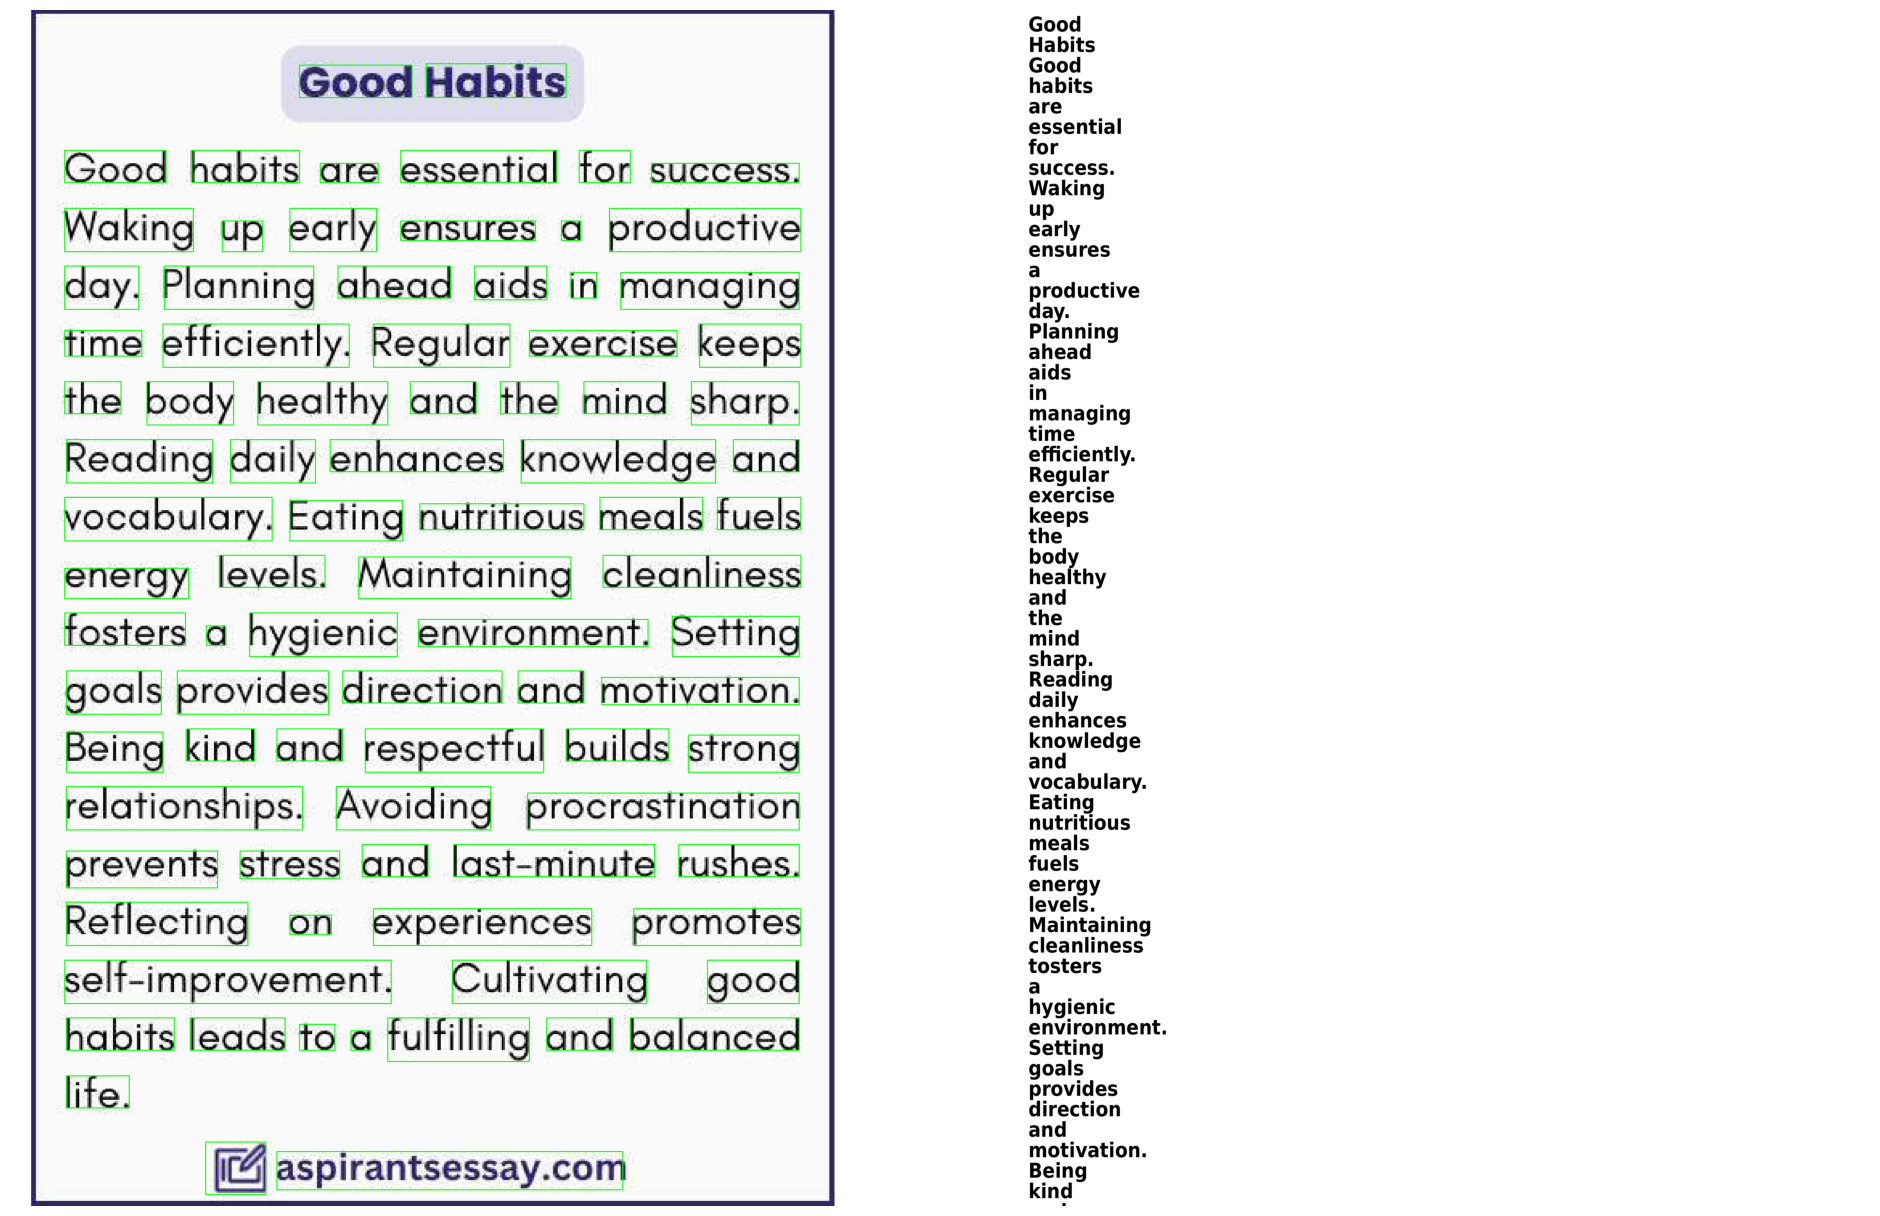

Processing pages: 100%|██████████| 5/5 [00:39<00:00,  7.81s/it]


Annotated PDF saved to output_pdf_english/annotated_output.pdf
OCR results saved to output_pdf_english/ocr_results.json


Processing pages:   0%|          | 0/3 [00:00<?, ?it/s]

Processing page 1...
Text: ", Probability: 33.0000
Text: 1, Probability: 41.0000
Text: 5, Probability: 43.0000
Text: 2, Probability: 50.0000
Text: ا, Probability: 38.0000
Text: 1, Probability: 43.0000
Text: 0, Probability: 38.0000
Text: 8, Probability: 47.0000
Text: 0, Probability: 17.0000
Text: 200700, Probability: 48.0000
Text: 20, Probability: 59.0000
Text: 3, Probability: 51.0000
Text: 8, Probability: 69.0000
Text: 7, Probability: 38.0000
Text: 21, Probability: 49.0000
Text: د, Probability: 43.0000
Text: عت, Probability: 31.0000
Text: 2ه, Probability: 29.0000
Text: :, Probability: 47.0000
Text: ١‏, Probability: 10.0000
Text: ََ, Probability: 7.0000
Text: 0, Probability: 84.0000
Text: 1, Probability: 31.0000
Text: |, Probability: 47.0000
Text: 0, Probability: 34.0000
Text: لحن, Probability: 5.0000
Text: 1, Probability: 71.0000
Text: علق, Probability: 53.0000
Text: ال, Probability: 88.0000
Text: 0, Probability: 78.0000
Text: يد, Probability: 44.0000
Text: صأ, Probability: 62.0000
Tex

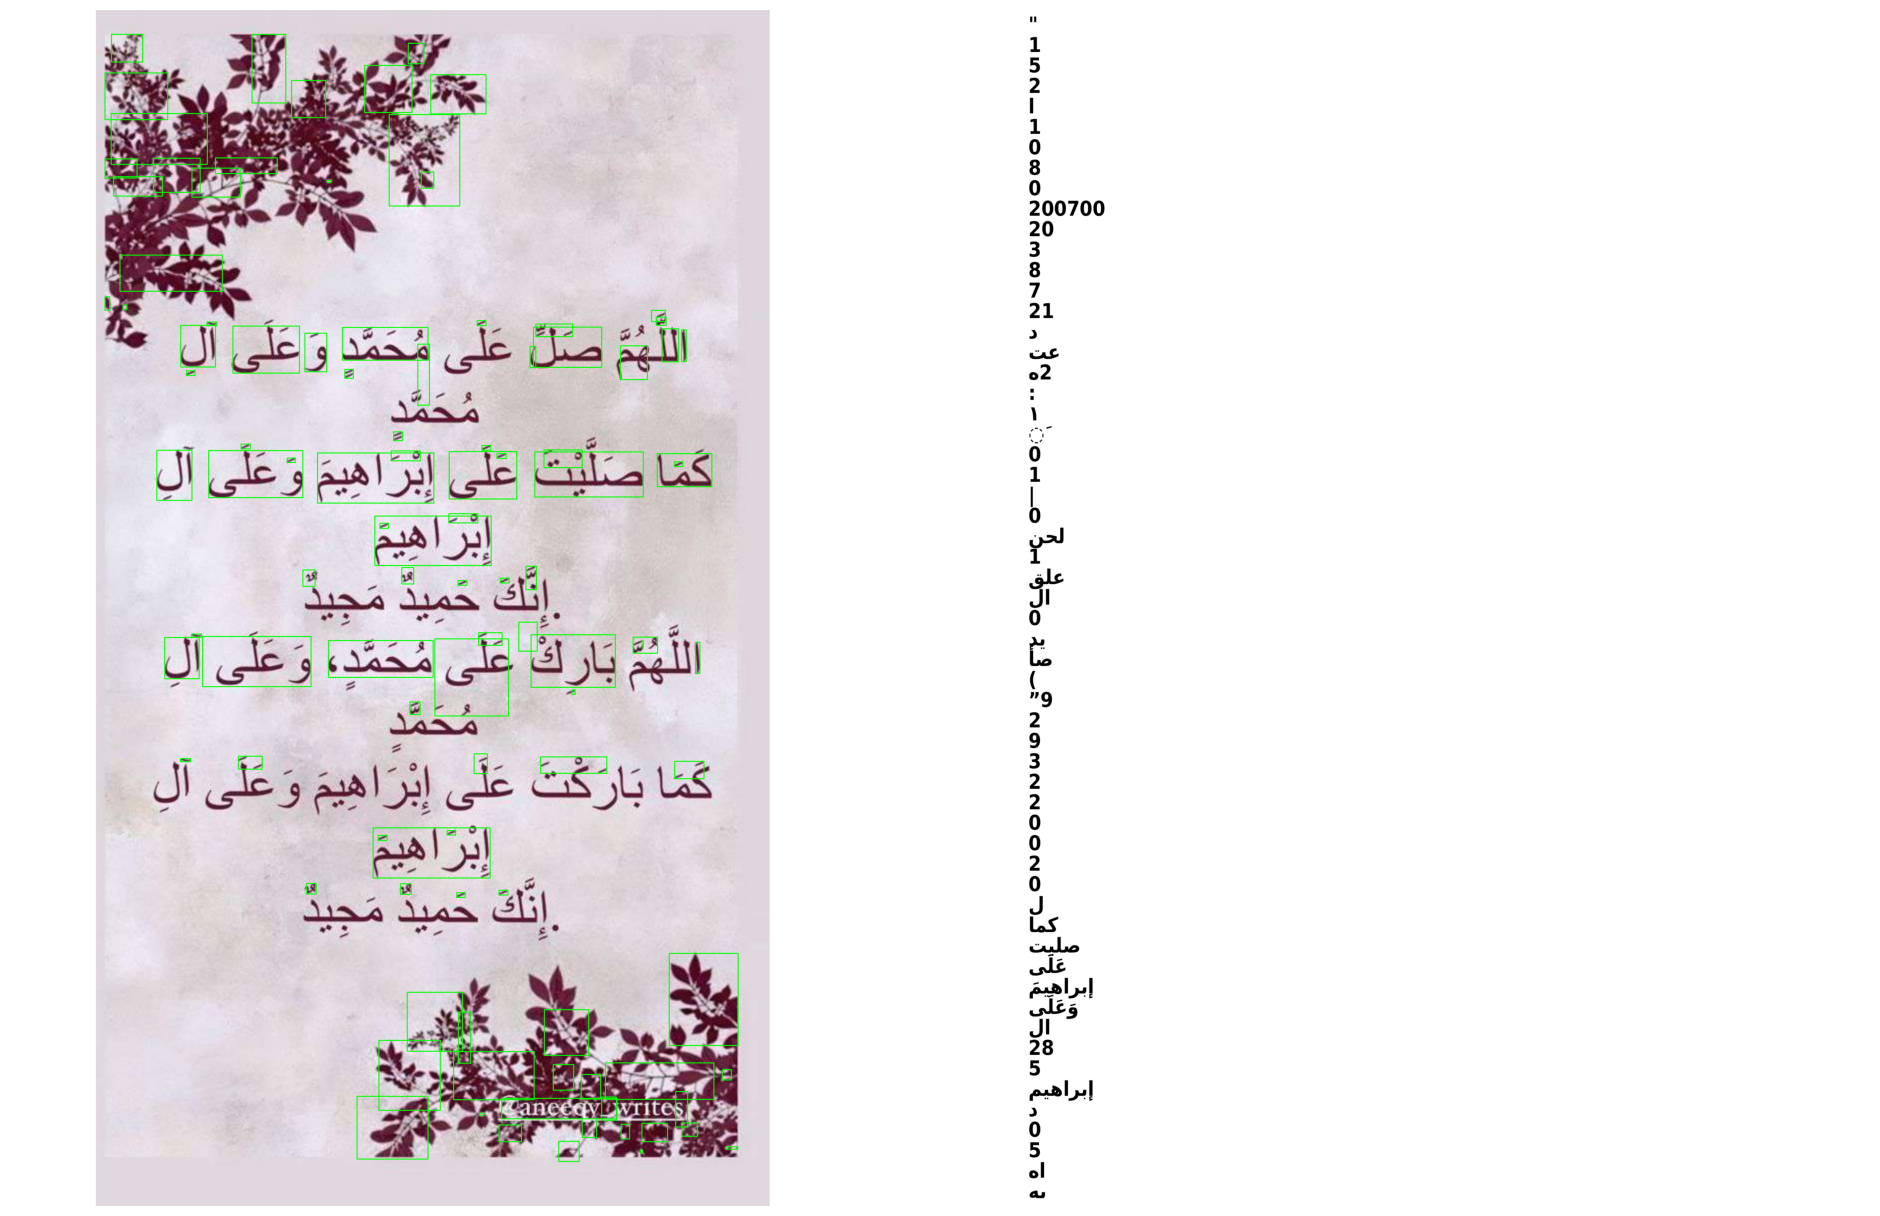

Processing pages:  33%|███▎      | 1/3 [00:08<00:16,  8.08s/it]

Processing page 2...
Text: |, Probability: 65.0000
Text: 9, Probability: 45.0000
Text: تان, Probability: 32.0000
Text: لوووط, Probability: 5.0000
Text: سوم, Probability: 17.0000
Text: سس, Probability: 36.0000
Text: يبب, Probability: 23.0000
Text: دي, Probability: 40.0000
Text: سس, Probability: 30.0000
Text: م, Probability: 36.0000
Text: », Probability: 14.0000
Text: 2, Probability: 41.0000
Text: >, Probability: 37.0000
Text: 0, Probability: 51.0000
Text: ]), Probability: 25.0000
Text: |, Probability: 48.0000
Text: ٠, Probability: 16.0000
Text: فون, Probability: 47.0000
Text: 1, Probability: 59.0000
Text: 1, Probability: 63.0000
Text: 0, Probability: 4.0000
Text: 1, Probability: 88.0000
Text: 5, Probability: 61.0000
Text: 55, Probability: 65.0000
Text: 2, Probability: 63.0000
Text: 0, Probability: 34.0000
Text: ا, Probability: 45.0000
Text: 59, Probability: 56.0000
Text: ل, Probability: 5.0000
Text: ع, Probability: 36.0000
Text: ٠ش‏, Probability: 17.0000
Text: ”0, Probability: 19.0000
T

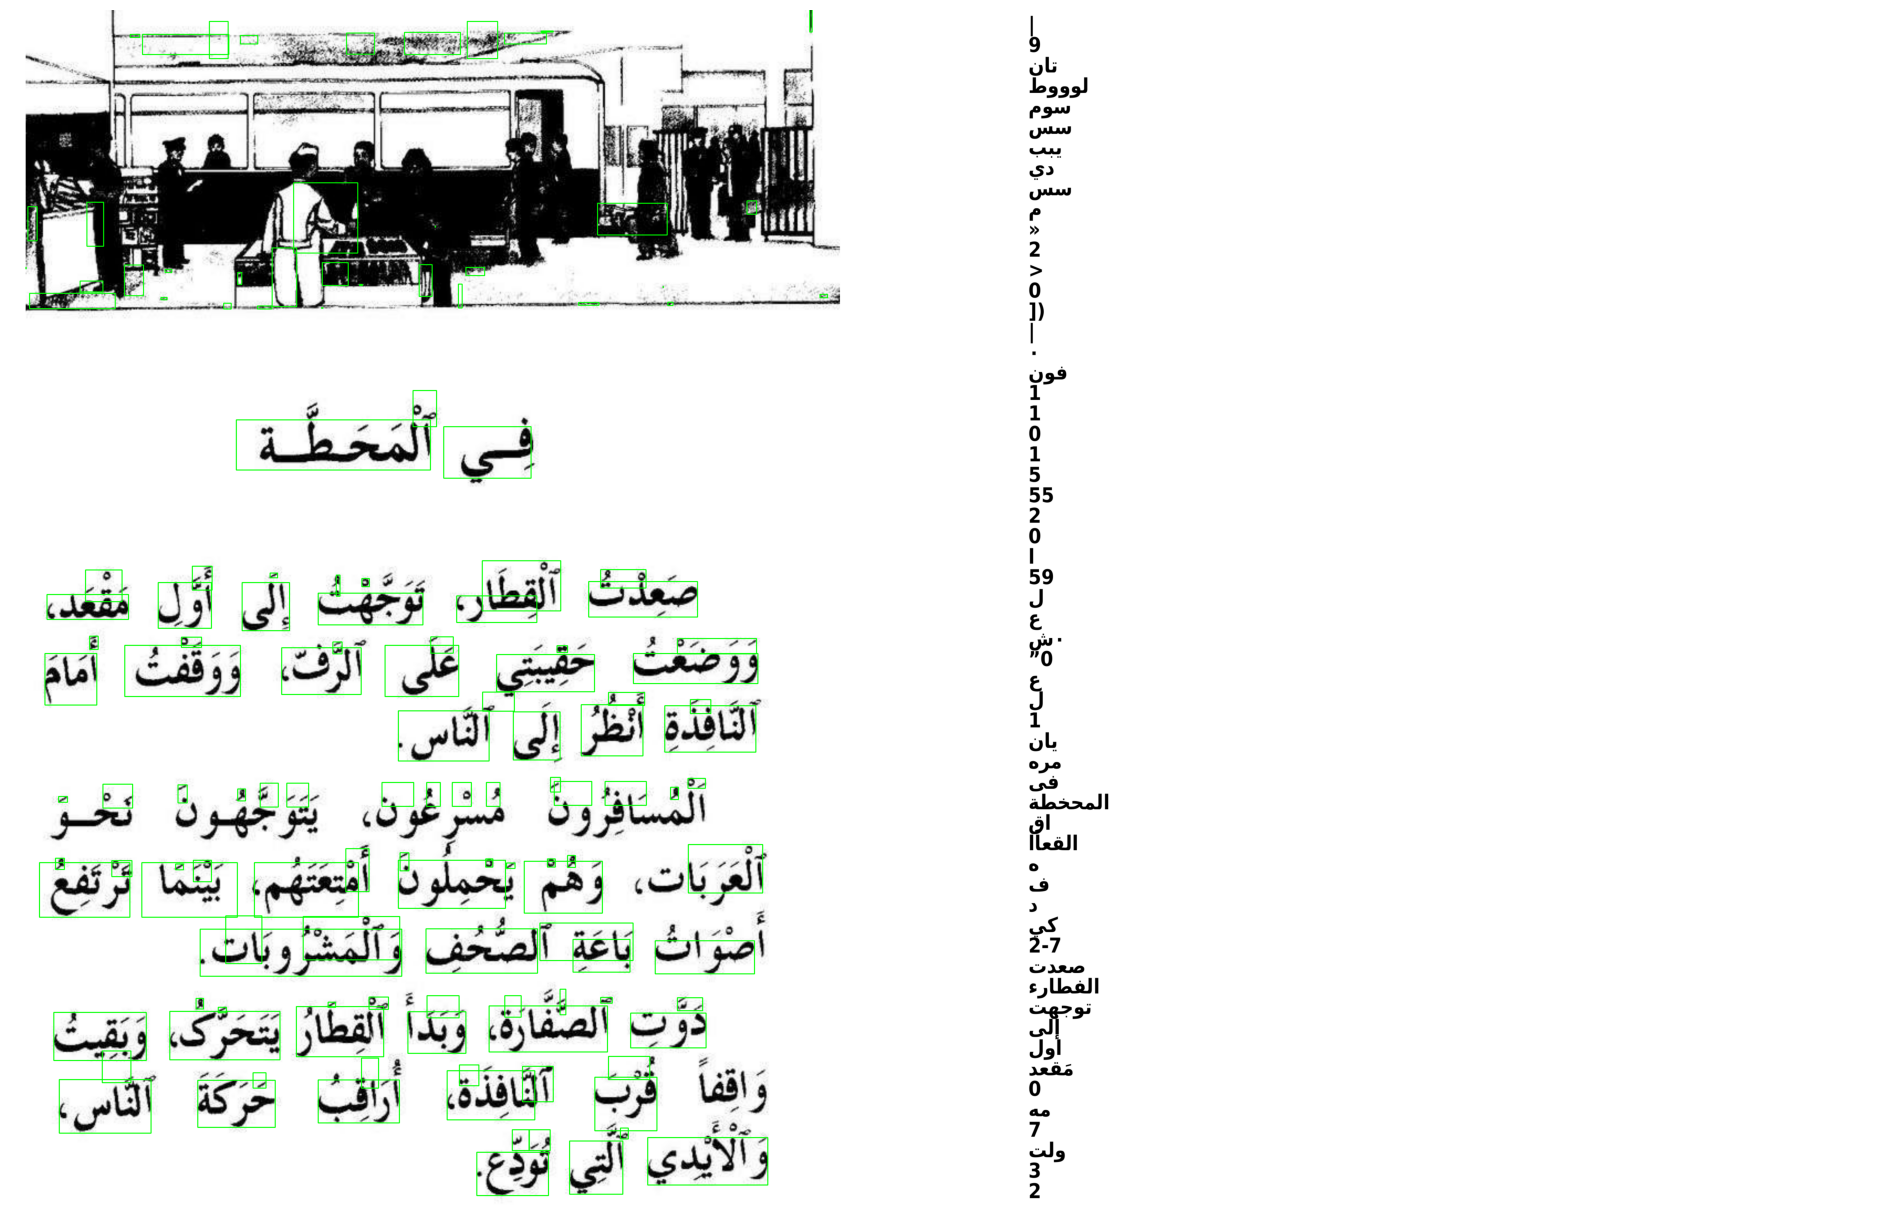

Processing pages:  67%|██████▋   | 2/3 [00:18<00:09,  9.21s/it]

Processing page 3...
Text: إن, Probability: 56.0000
Text: الْحَيَاةً, Probability: 40.0000
Text: قَصِيدَةٌ, Probability: 43.0000
Text: أنْييَاتها, Probability: 43.0000
Text: أَعْمَارْنَا, Probability: 18.0000
Text: وَالْمَوْتٌ, Probability: 23.0000
Text: فيهًا, Probability: 74.0000
Text: الْقَافبَة, Probability: 49.0000
Text: أَيْنَ, Probability: 65.0000
Text: الْفُصُورٌ, Probability: 41.0000
Text: الشتَّامِخَاتٌ, Probability: 10.0000
Text: وَأَهْلُهَ, Probability: 6.0000
Text: اد, Probability: 38.0000
Text: الْجَمِيعٌ, Probability: 63.0000
Text: فَهَلْ, Probability: 37.0000
Text: لَهُمْ, Probability: 50.0000
Text: مِنْ, Probability: 85.0000
Text: بَاقبَة, Probability: 61.0000
Text: لو, Probability: 86.0000
Text: أن, Probability: 57.0000
Text: حا, Probability: 32.0000
Text: حَالد, Probability: 33.0000
Text: بن, Probability: 2.0000
Text: الوَرَى, Probability: 55.0000
Text: مَا, Probability: 80.0000
Text: مَاتَ, Probability: 77.0000
Text: هَارُونٌ, Probability: 23.0000
Text: وَمَات, Prob

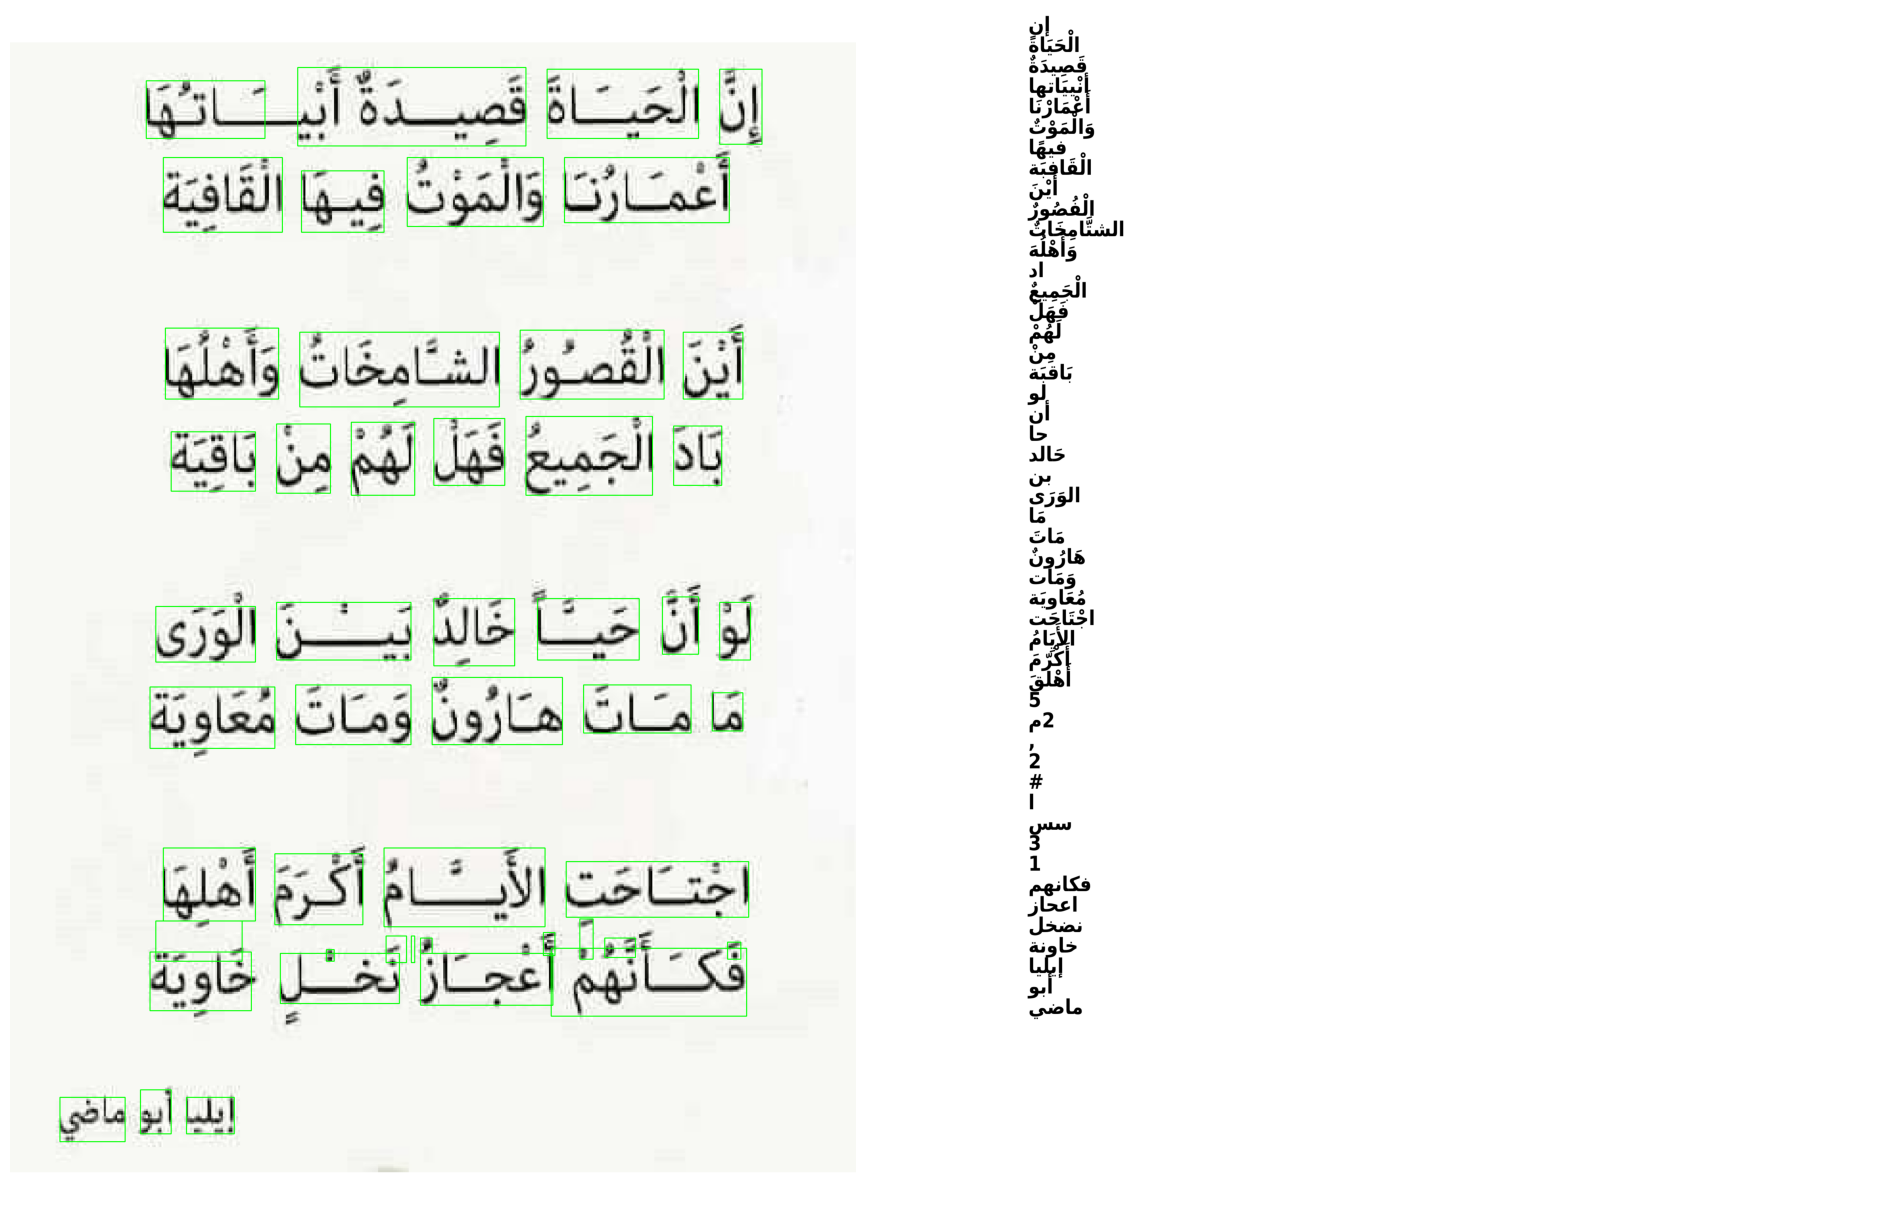

Processing pages: 100%|██████████| 3/3 [00:24<00:00,  8.18s/it]


Annotated PDF saved to output_pdf_arabic/annotated_output.pdf
OCR results saved to output_pdf_arabic/ocr_results.json


In [8]:
# English PDF
english_pdf_path = '/content/Text Images_English.pdf'
ocr_pdf_to_individual_json(english_pdf_path, language='eng', output_dir="output_pdf_english", save_pdf=True)

# Arabic PDF
arabic_pdf_path = '/content/Text Images _Arabic.pdf'
ocr_pdf_to_individual_json(arabic_pdf_path, language='ara', output_dir="output_pdf_arabic", save_pdf=True)

In [9]:
#----------------------------------------------------------------------------------